<a href="https://colab.research.google.com/github/AminaTkh/AlanTuringInstitute_Bias_in_AI/blob/main/Forms-and-Quantification-of-Bias-in-AI/Practice_1_Explore_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Milestone 3: Sources, Forms, and Quantification of Bias and Discrimination in Supervised Learning**
# **PRACTICE NOTEBOOK 1 - Explore given data**


In this part of the course, we will look for bias using a practical example. A  company is looking to hire a new employee. They use a machine learning algorithm to select the top candidates. The candidates are assigned either 0 if they're not selected or 1 if they are.

There are 4 practice notebooks in total (current one in red):
1. <font color='red'> **Explore given data to: detect potential bias early & check for proxies**</font>
2. Evaluate model bias "manually"
3. Evaluate model bias using **holisticai** library
4. Example code to get confidence intervals for a metric (nothing to do)

Instructions to complete in each parts are in bold. Intermediate results are given so one can continue the exercise.

This is notebook number 1.

In this notebook, we:
- Import modules, define some useful functions, and load the data
- Check for nan values
- Explore the demographics of the candidates and the label distribution per group
- Look for proxies in the data
- See if we can build a model that "guess" the gender/ethnicity

## **0 - Import modules, load data and useful functions**

In [1]:
#imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import imblearn

In [2]:
# Load data

from sklearn.datasets import fetch_openml
bunch = fetch_openml(data_id=44270)
raw_data = bunch['frame']
raw_data


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Label,Gender,Ethnicity,0,1,2,3,4,5,6,...,40,41,42,43,44,45,46,47,48,49
0,1,Female,Black,-0.178832,0.147077,0.775331,-0.427889,0.640818,-0.610427,-1.023371,...,0.513206,-0.042387,-0.355889,-0.465837,-2.832634,0.917297,-0.241052,-2.122105,0.253170,0.164617
1,1,Male,Hispanic,0.092276,0.122023,0.482935,-0.232131,-1.939064,-1.140216,-0.833250,...,-1.203151,0.750136,-1.417751,1.254152,0.631731,1.665469,-0.388293,-0.804782,-0.227182,0.412375
2,0,Female,Hispanic,-1.703377,-0.962149,-0.785495,-0.633902,-0.334718,-1.555958,0.825006,...,0.249654,0.368800,0.079523,-0.932425,-0.693293,-0.114197,-1.252067,0.834270,-0.463270,0.559294
3,0,None,None,-1.229715,-1.342997,-0.093382,0.136900,1.195076,-0.582687,0.052355,...,0.667730,0.595494,0.454502,-0.366884,-0.399758,1.113102,0.126707,0.474569,-0.158103,1.197710
4,1,Male,Hispanic,-0.363013,1.264307,1.667603,0.903941,-0.062840,0.680886,0.389930,...,-0.494161,0.784050,-0.311236,2.447118,1.127650,0.086733,-0.381553,0.209684,0.197809,-0.879914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,Female,Hispanic,-0.057075,1.791513,-1.065756,-0.783341,-0.559215,1.042646,-1.154058,...,-0.335082,0.709753,0.021583,1.718576,1.171804,0.430075,3.340726,1.349216,1.481516,0.070563
9996,1,Male,Black,0.582066,0.086788,0.167259,-1.672798,1.537135,-1.113315,0.222907,...,-0.562594,0.150314,-0.072920,-1.841719,-0.807065,-0.793955,-1.098300,-1.474154,-0.828826,-0.891166
9997,0,Male,White,-1.355098,-0.321228,-0.204290,0.498632,1.634130,0.847070,-0.552140,...,-1.204719,0.688433,-1.781911,0.275032,0.690859,0.666878,0.644440,0.127891,1.277781,-0.744428
9998,1,Male,White,-0.526557,2.174463,-0.979082,-0.681536,-0.145515,1.703135,0.947010,...,-0.487367,2.043764,-1.570147,0.861712,-0.939181,0.090775,-1.153183,-1.362903,-1.424866,-0.374579


In [3]:
def plot_cm(y_true,y_pred,labels = [1,0],display_labels = [1,0], ax = None):
  cm = confusion_matrix(y_true,y_pred,labels = labels)
  if ax is None:
    fig, ax = plt.subplots()
  else:
    fig = ax.figure
  sns.heatmap(cm, annot=True, ax = ax, cmap='viridis',fmt='g')

  ax.set(xticklabels=display_labels,
          yticklabels=display_labels,
          ylabel="True label",
          xlabel="Predicted label")
  return cm
def split_data_from_df(data):
  y = data['Label'].values
  # g = data['Gender'].values
  # e = data['Ethnicity'].values
  X = data[np.arange(50).astype(str)].values
  filter_col = ['Ethnicity','Gender'] + [col for col in data if str(col).startswith('Ethnicity_')] + [col for col in data if str(col).startswith('Gender_')]
  dem = data[filter_col].copy()
  return X,y,dem
def encode(df):
  g_enc = LabelEncoder()
  e_enc = LabelEncoder()
  df['Gender'] = g_enc.fit_transform(df['Gender'])
  df['Ethnicity'] = e_enc.fit_transform(df['Ethnicity'])
  return df, g_enc,e_enc
def resample_equal(df,cat):
  df['uid'] = df[cat] + df['Label'].astype(str)
  enc = LabelEncoder()
  df['uid'] = enc.fit_transform(df['uid'])
  # Resample
  uid = df['uid'].values
  res = imblearn.over_sampling.RandomOverSampler(random_state=6)
  df_res,euid = res.fit_resample(df,uid)
  df_res = pd.DataFrame(df_res,columns = df.columns)
  df_res = df_res.sample(frac=1).reset_index(drop=True)
  df_res['Label'] = df_res['Label'].astype(float)
  return df_res

## **1- Data presentation**

Each row in the data represent a candidate. There are 3 components to the data:
- y : the "ground-truth" label in the "Label" column. This is whether the candidate should actually receive a positive or negative rating (repsectively 1 or 0).
- X : the input features in the columns 0 to 19. There are 20 features for each candidates, extracted from resume and video interview.
- dem : the demographic information in the columns "Gender" or "Ethnicity".

We extract them from a given dataframe using the pre-defined function "split_data_from_df" to be used as demonstrated below.

In [4]:
data = raw_data.copy()
X,y,dem = split_data_from_df(data)
print(X.shape, y.shape)
display(dem.head(3))

(10000, 50) (10000,)


,Ethnicity,Gender
0,Black,Female
1,Hispanic,Male
2,Hispanic,Female


In this section we will:
1. Look for nan values
2. Explore the demographics of the dataset and distribution of labels
3. Check for proxies

## **2. Nan values**

**Questions** :
- **Check for the number of nan values in each column of *data*.** <br>
    *Expected results*: No nan values in the features or labels. Nan values  for columns Gender and Ethnicity.


- **How are these nan values distributed ?**
Are the people missing gender information the same as the ones missing ethnicity information ? You can use the missingno library to visualise this on the *dem* dataframe ([see demo here](https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/)). Check your assumptions numerically. <br>
    *Expected results*: You should find that for a given candidate, either both the gender or ethnicity is missing, either all of the information is there. We will call the group of candidates with missing information "the nan group".

In [ ]:
data = raw_data.copy() # work with the "data" dataframe (simple copy of the raw dataframe)

In [ ]:
data.head(5)

,Label,Gender,Ethnicity,0,1,2,3,4,5,6,...,40,41,42,43,44,45,46,47,48,49
0,1,Female,Black,-0.178832,0.147077,0.775331,-0.427889,0.640818,-0.610427,-1.023371,...,0.513206,-0.042387,-0.355889,-0.465837,-2.832634,0.917297,-0.241052,-2.122105,0.253170,0.164617
1,1,Male,Hispanic,0.092276,0.122023,0.482935,-0.232131,-1.939064,-1.140216,-0.833250,...,-1.203151,0.750136,-1.417751,1.254152,0.631731,1.665469,-0.388293,-0.804782,-0.227182,0.412375
2,0,Female,Hispanic,-1.703377,-0.962149,-0.785495,-0.633902,-0.334718,-1.555958,0.825006,...,0.249654,0.368800,0.079523,-0.932425,-0.693293,-0.114197,-1.252067,0.834270,-0.463270,0.559294
3,0,None,None,-1.229715,-1.342997,-0.093382,0.136900,1.195076,-0.582687,0.052355,...,0.667730,0.595494,0.454502,-0.366884,-0.399758,1.113102,0.126707,0.474569,-0.158103,1.197710
4,1,Male,Hispanic,-0.363013,1.264307,1.667603,0.903941,-0.062840,0.680886,0.389930,...,-0.494161,0.784050,-0.311236,2.447118,1.127650,0.086733,-0.381553,0.209684,0.197809,-0.879914


In [5]:
data.isnull().sum().to_frame(name='missing_values').query('missing_values > 0')


,missing_values
Gender,1238
Ethnicity,1238


In [6]:
#checking whether all rows with missing values for Gender have missing values for Ethnicity as well
verify_df = data.loc[(data['Gender'].isnull()) & (data['Ethnicity'].isnull())]
verify_df.shape


(1238, 53)

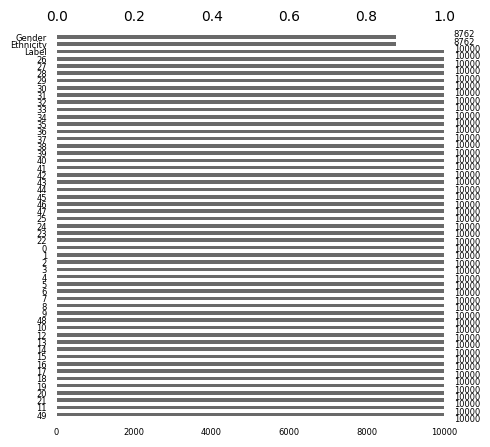

In [17]:
import missingno as msno
fig = msno.bar(data, figsize=(5,5), fontsize = 6, sort="descending")



## **3. Demographics of the dataset and average ground-truth success rate for each group**

**Questions** :
- **What groups are represented for gender/ethnicity?** Draw histograms of the *Gender* and *Ethnicity* columns in *data*.
- **Exploring the labels in y, what proportions of all the candidates population receives a positive outcome ?**
- **Now let's calculate the proportion of positive outcome (or success rate) for each gender and ethnicity.**

Notes:
- Because the label is 0 or 1, calculating the proportion of positive outcome is the same as calculating the mean y values.
- For this section, we will replace the nan values in the *Gender* and *Ethnicity* columns with a string so that our code will treat these candidates as if they were their own group.
- Usual histogram plotting functions ignore nan values. Because we have changed these into strings, the nan group won't be ignored here.

In [18]:
# replace nan values with 'nan' string
data = raw_data.copy() # work with the "data" dataframe (simple copy of the raw dataframe)
data = data.fillna("nan")

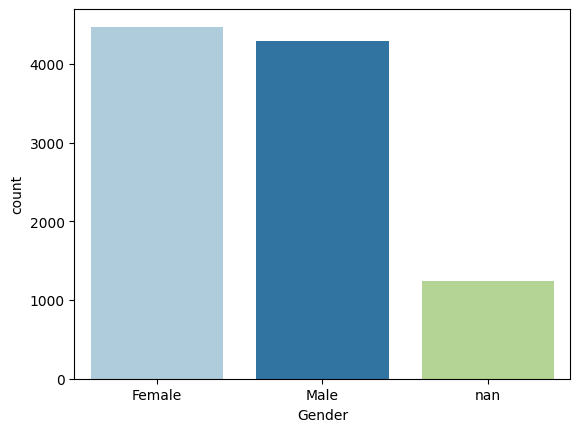

In [19]:
sns.set_palette("Paired")
sns.countplot(x=data['Gender'],
                   order=data['Gender'].value_counts(ascending=False).index);

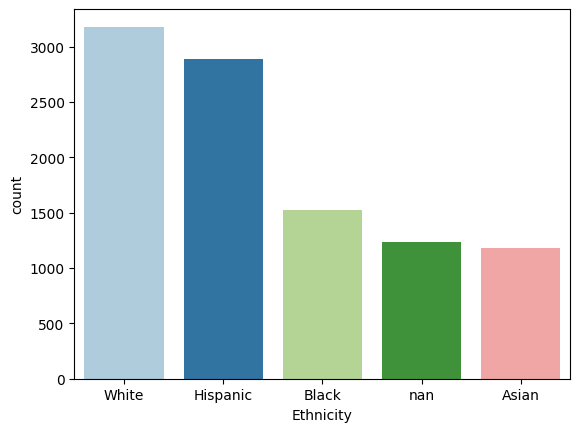

In [20]:
sns.set_palette("Paired")
sns.countplot(x=data['Ethnicity'],
                   order=data['Ethnicity'].value_counts(ascending=False).index);

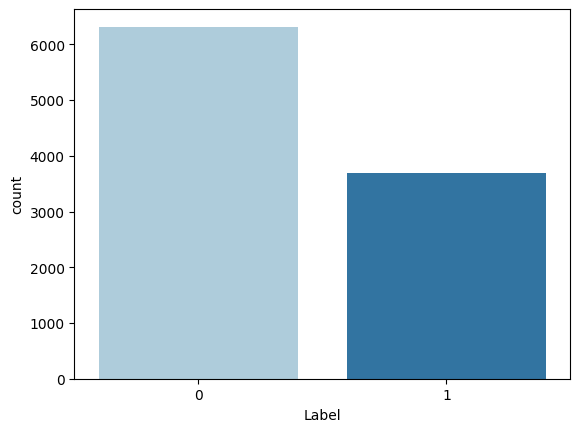

In [22]:
sns.set_palette("Paired")
sns.countplot(x=data['Label'],
                   order=data['Label'].value_counts(ascending=False).index);

In [34]:
#SR calculations
Mean_Score_per_Gender = data.groupby(by = ['Gender'])['Label'].mean().to_frame(name = 'Success Rate')
Mean_Score_per_Ethnicity = data.groupby(by = ['Ethnicity'])['Label'].mean().to_frame(name = 'Success Rate')

In [35]:
Mean_Score_per_Gender

,Success Rate
Gender,
Female,0.379919
Male,0.374359
nan,0.305331


In [36]:
Mean_Score_per_Ethnicity

,Success Rate
Ethnicity,
Asian,0.325424
Black,0.353289
Hispanic,0.387790
White,0.398238
nan,0.305331


You should find the following success rates per group:


| Group | Success Rate |
| -: | :-: |
**Mean score per gender**
| Female |  0.379919 |
| Male |  0.374359 |
|nan      |   0.305331 |
|**Mean score per ethnicity**
|Asian     |  0.325424|
| Black    |   0.353289|
|Hispanic   | 0.387790|
|White     |  0.398238|
|nan      |   0.305331|


**Note on the nan group :**
As seen in the results, the 'nan' group has the lowest success rate. If we continue the fairness analysis by leaving it in, we will see that it is also the group against which there is the strongest bias. Because we have no prior information on how the "nan" group was constituted and who is in it, it is difficult to draw any conclusion on what this means. In an ideal world, there should be no subgroups constituted at random against which there's an observable bias. However, we do not know whether this group is randomly constituted or not. Possible reasons for missing data could be: (i) people opted out of providing their ethnicity or gender, (ii) these features could have been reverse-engineered from a photo or video and there was no video available for these candidates, or (iii) a reason that correlates somehow with less qualified candidates.

In the remaining of this course, we remove the nan group from the analysis for simplicity. In a real-life context, the reason behind the bias on the nan group should be investigated and mitigating this bias could be needed.

In [37]:
# remove all nans
data = data[data['Gender']!= 'nan'].copy()

## **4. Looking for proxy features**

The features do not include explicitely any protected characteristics related to gender or ethnicity. It can de facto be deemed fair with respect to the *Fairness Through Unawareness* definition. However sometimes it is possible to find proxies for protected attributes in the data, meaning that a specific feature might be strongly correlated with a protected characteristic.

We can check whether a particular feature is highly correlated with ethnicity or gender by calculating the pearson correlation coefficients of each feature with the gender or ethnicity. Let's demonstrate this for gender only. The same can be done for ethnicity as an exercise.

The following code extracts from the data:

- the input features X
- the gender g




In [38]:
# copy raw data and drop nan values
df = raw_data.copy()
df = df.dropna()
# Extract X and g
X,_,dem = split_data_from_df(df)
g = dem['Gender'].values
enc = LabelEncoder()
g = enc.fit_transform(g)
print("Label for Male is %d. Label for Female is %d"%(enc.transform(['Male'])[0],enc.transform(['Female'])[0]))

Label for Male is 1. Label for Female is 0


**Questions** :
- **Calculate the correlation between the gender g and all other features.**
  - using scipy.stats.pearsonr get the correlation coefficient between g and each feature. You can for instance use a loop to go through each features and store results in a list or 1D array.
  - plot a graph with the correlation coefficient on the y axis and features on the X axis.
- **Is there any feature correlating highly with gender?**

In [80]:
from scipy import stats
correlations = pd.DataFrame(columns = ['Features', 'CorrelationCoeff'])
correlations.set_index('Features')
for i in range(50):
  correlations.loc[str(i)] = stats.pearsonr(g, df[str(i)]).statistic


<Axes: ylabel='CorrelationCoeff'>

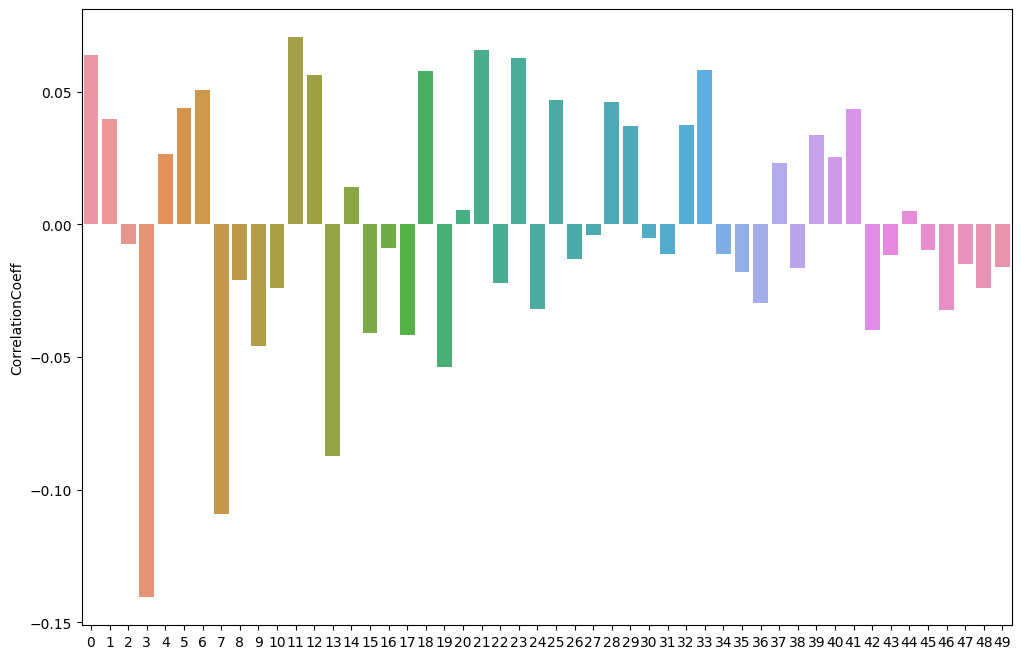

In [82]:
plt.figure(figsize=(12,8))
sns.barplot(x = correlations.index, y = correlations.CorrelationCoeff)


## **5. Can we still predict the protected characteristic using the entire set of features?**

The previous section should show that there is no single feature that is highly correlated with gender in this case.

However, can we still infer the gender or ethnicity of a participant from the features themselves? We will try to build a model that predicts the gender or ethnicity from the features.

In this section we use a simple RidgeClassifier to try and do this. The following code defines the classifier, and prepare the data for the task. We will try to predict whether the candidate is a Female or Male.

As an optional exercise, you may also repeat that exercise for Black/White ethnicity. This is interesting as the dataset is imbalanced regarding these groups (many more White candidates than Black), hence the results are not as straightforward as for Male/Female.

### **5.1. Predict Male/Female gender**

In the following code we:
- encode the *Gender* column into integers
- split the data into train and test set. For this section you will need:
  - X_train , X_test. are the train and test input features
  - g_train, g_test. contain the encoded gender (0 for Female; 1 for Male) and are used as labels in this section
- initialize the model

In [83]:
# copy raw data and drop nan values
df = raw_data.copy()
df = df.dropna()
# encode 'Gender' column
enc = LabelEncoder()
df['Gender'] = enc.fit_transform(df['Gender'])
print("Label for Male is %d. Label for Female is %d"%(enc.transform(['Male'])[0],enc.transform(['Female'])[0]))
# split data train/test (from data without nan)
data_train, data_test = train_test_split(df,test_size = 0.3,random_state=41)
# get X,y, gender, ethnicity
X_train,_,dem_train = split_data_from_df(data_train)
g_train = dem_train['Gender']
X_test,_,dem_test = split_data_from_df(data_test)
g_test = dem_test['Gender']
# define model
model = RidgeClassifier(random_state = 42)

Label for Male is 1. Label for Female is 0


**Instructions:**
- **Fit the model on the train set**
- **Compute the accuracy and confusion matrix on the test set.**  You can use *accuracy_score* (sklearn.metrics) and *plot_cm* (defined in 1)
- **Check the precision, recall and f1 score for each class.** You can use *precision_recall_fscore_support* (sklearn.metrics).

In [92]:
model.fit(X_train, g_train)
y_pred = model.predict(X_test)
print('Overall accuracy = ', accuracy_score(g_test, y_pred))

Overall accuracy =  0.6135412704450361


array([[774, 493],
       [523, 839]])

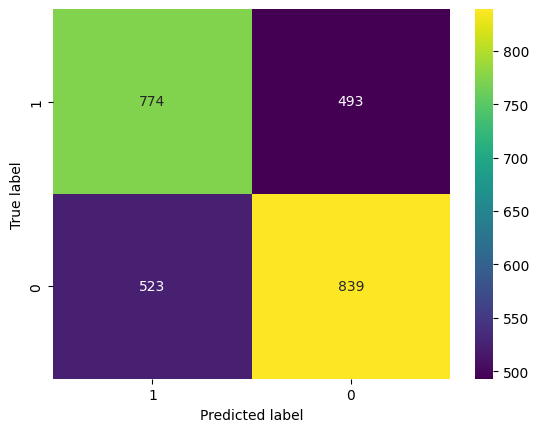

In [93]:
plot_cm(g_test, y_pred)

In [94]:
precision_recall_fscore_support(g_test, y_pred)

(array([0.62987988, 0.59676176]),
 array([0.61600587, 0.61089187]),
 array([0.62286563, 0.60374415]),
 array([1362, 1267]))

You should obtain the following results:

Overall Accuracy: 0.61

| Group | Precision | Recall | f1 |
| --- | --- | --- | --- |
| Female | 0.60| 0.61 | 0.60 |
| Male |  0.63| 0.62 | 0.62 |

Some possible reasons behind the fact that the features enable gender classification are:
 - There are some video, photo or voice features that enable gender recognition, or any other ensemble of features that do the same.
 - There are some specific proxy variables that are correlated with gender, as for instance  "Maternity leave" or "Employment length". We have seen from section 4 that this was not the case.


### **5.2. (OPTIONAL) Predict Black/White ethnicity**

In the following code, we perform the same steps as for gender:
- only keep *White* and *Black* candidates
- encode the *Ethnicity* column into integers
- split the data into train and test set. For this section you will need:
  - X_train , X_test. are the train and test input features
  - e_train, e_test. contain the encoded ethnicity (0 for Black; 1 for White)
- initialize the model

In [112]:
# copy raw data and drop nan values
df = raw_data.copy()
df = df.dropna()
# remove non Black or non White for the purpose of this exercise
df = data[(data['Ethnicity'] == 'White') | (data['Ethnicity'] == 'Black')].copy()
# encode 'Ethnicity' column
enc = LabelEncoder()
df['Ethnicity'] = enc.fit_transform(df['Ethnicity'])
print("Label for White is %d. Label for Black is %d"%(enc.transform(['White'])[0],enc.transform(['Black'])[0]))
# split data train/test (from data without nan)
data_train, data_test = train_test_split(df,test_size = 0.3,random_state=41)
# get X,y, gender, ethnicity
X_train,_,dem_train = split_data_from_df(data_train)
e_train = dem_train['Ethnicity']
X_test,_,dem_test = split_data_from_df(data_test)
e_test = dem_test['Ethnicity']
# define model
model = RidgeClassifier(random_state = 42)

Label for White is 1. Label for Black is 0


**Instructions.** As in the gender case:
- **Fit the model on the train set**
- **Compute the accuracy and confusion matrix on the test set.**  You can use *accuracy_score* (sklearn.metrics) and *plot_cm* (defined in 1)
- **Check the precision, recall and f1 score for each class.** You can use *precision_recall_fscore_support* (sklearn.metrics).
- **Count the number of *Black* and *White* candidates in the test dataset.**

In [113]:
model.fit(X_train, e_train)
y_pred = model.predict(X_test)
print('Overall accuracy = ', accuracy_score(e_test, y_pred))

Overall accuracy =  0.6858156028368795


array([[849,  86],
       [357, 118]])

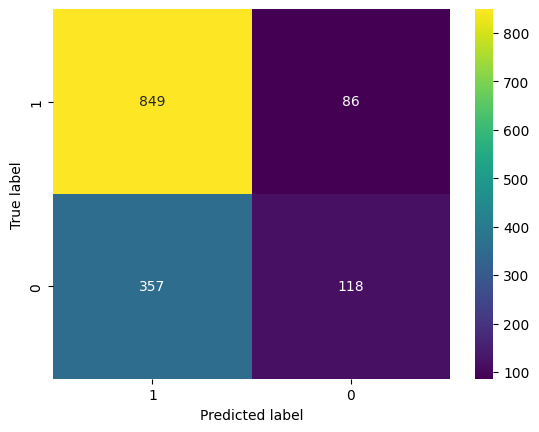

In [114]:
plot_cm(e_test, y_pred)

In [107]:
precision_recall_fscore_support(e_test, y_pred)

(array([0.57843137, 0.7039801 ]),
 array([0.24842105, 0.90802139]),
 array([0.34756996, 0.79308734]),
 array([475, 935]))

In [105]:
e_test.value_counts()

1    935
0    475
Name: Ethnicity, dtype: int64

You should obtain the following results:

Overall Accuracy: 0.69


| Group | Precision | Recall | f1 |
| --- | --- | --- | --- |
| Black | 0.70 | 0.91 | 0.79 |
| White |  0.58| 0.25 | 0.35 |


Test set counts: {*White*: 935, *Black*: 475}

You should observe in the confusion matrix that there are significantly less prediction for Black than for White. This would even happen with a perfect model as there is less candidates categorized as *Black* than *White* in the dataset. In these cases, the precision and recall scores help to judge the quality of a model to predict for each class.

Upon further inspection, it seems the model has learnt to predict almost every instance as White. So it is hard to get a sense as to whether Ethnicity can actually be inferred from the features.

To tackle this, we can resample the data, i.e. randomly oversampling the minority class or undersampling the majority class so there is the same amount of each class. In theory, one should only resample the training data as the outcome for "real-life" test data is not available so we cannot resample it. However for the purpose of this class, we will resample the whole data.

### **5.3. (OPTIONAL) Predict *Black/White* ethnicity after rebalancing the data**

In the following code, we undersample the data and repeat the experiment.

In [120]:
# copy raw data and drop nan values
df = raw_data.copy()
df = df.dropna()
# get data
df = data[(data['Ethnicity'] == 'White') | (data['Ethnicity'] == 'Black')].copy()
X,_,dem = split_data_from_df(df)
e = dem['Ethnicity'].values
# resample
print('Original dataset counts', Counter(e))
res = RandomUnderSampler(random_state=42)
X,e = res.fit_resample(X,e)
print('Resampled dataset counts', Counter(e))
# encode ethnicity
enc = LabelEncoder()
e = enc.fit_transform(e)
# split data train/test (from data without nan)
X_train, X_test, e_train, e_test = train_test_split(X,e,test_size = 0.3,random_state=41)

Original dataset counts Counter({'White': 3179, 'Black': 1520})
Resampled dataset counts Counter({'Black': 1520, 'White': 1520})


**Instructions.** Once again:
- **Fit the model on the train set**
- **Compute the accuracy and confusion matrix on the test set.**  You can use *accuracy_score* (sklearn.metrics) and *plot_cm* (defined in 1)
- **Check the precision, recall and f1 score for each class.** You can use *precision_recall_fscore_support* (sklearn.metrics).

In [121]:
model.fit(X_train, e_train)
y_pred = model.predict(X_test)
print('Overall accuracy = ', accuracy_score(e_test, y_pred))

Overall accuracy =  0.6271929824561403


array([[277, 153],
       [187, 295]])

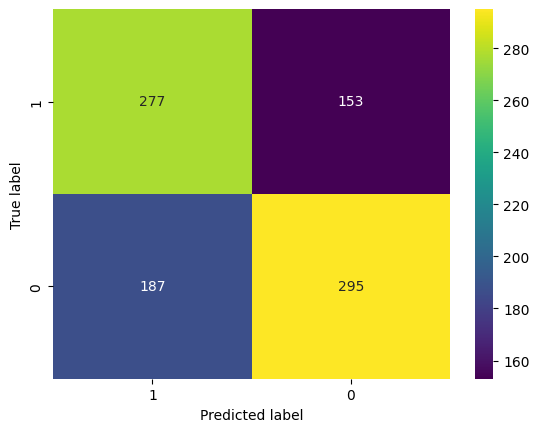

In [122]:
plot_cm(e_test, y_pred)

In [123]:
precision_recall_fscore_support(e_test, y_pred)

(array([0.65848214, 0.59698276]),
 array([0.6120332 , 0.64418605]),
 array([0.6344086, 0.6196868]),
 array([482, 430]))

In [127]:
pd.DataFrame(e_test).value_counts()

0    482
1    430
dtype: int64

You should obtain the following results:

Overall Accuracy: 0.63


| Group | Precision | Recall | f1 |
| --- | --- | --- | --- |
| Black | 0.60 | 0.64 | 0.62 |
| White |  0.66| 0.61 | 0.63 |


Test set counts: {*White*: 430, *Black*: 482}